# BDA Contest Modeling (Boosting Ensemble)
이 노트북은 XGBoost, LightGBM, CatBoost 모델을 사용하여 수료 여부를 예측합니다.
**GitHub에 업로드된 데이터**를 직접 불러와 3가지 모델의 앙상블(Soft Voting)을 수행합니다.

In [1]:
# 필요한 라이브러리 설치 (최초 1회 실행)
!pip install xgboost lightgbm catboost numpy pandas scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# 한글 폰트 설정 (Windows 기준)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# GitHub Raw Data URLs
REPO_URL = 'https://raw.githubusercontent.com/choicompany/bdadacon/main'
TRAIN_URL = f'{REPO_URL}/preprocessing/train_processed.csv'
TEST_URL = f'{REPO_URL}/preprocessing/test_processed.csv'
RAW_TEST_URL = f'{REPO_URL}/rawdata/test.csv'

In [13]:
# 데이터 불러오기 (GitHub에서 직접 로드)
print(f"Loading Train Data from: {TRAIN_URL}")
train_df = pd.read_csv(TRAIN_URL)

print(f"Loading Test Data from: {TEST_URL}")
test_df = pd.read_csv(TEST_URL)

# LightGBM/XGBoost Error Fix: Remove ALL special characters from column names
# Only allow letters, numbers, and underscores (whitelist approach)
regex = re.compile(r"[^A-Za-z0-9_]")
train_df.columns = [regex.sub("_", str(col)) for col in train_df.columns]
test_df.columns = [regex.sub("_", str(col)) for col in test_df.columns]

# Convert boolean columns to int (0 or 1) for compatibility with some models (e.g., XGBoost)
for col in train_df.select_dtypes(include='bool').columns:
    train_df[col] = train_df[col].astype(int)
for col in test_df.select_dtypes(include='bool').columns:
    test_df[col] = test_df[col].astype(int)

# Convert any remaining 'object' type columns to numerical (e.g., Label Encoding)
for col in train_df.select_dtypes(include='object').columns:
    train_df[col] = train_df[col].astype('category').cat.codes
for col in test_df.select_dtypes(include='object').columns:
    test_df[col] = test_df[col].astype('category').cat.codes

# 학습 데이터와 타겟 분리
X = train_df.drop(columns=['completed'])
y = train_df['completed']
X_test = test_df.copy()

print(f"Train Shape: {X.shape}")
print(f"Test Shape: {X_test.shape}")

Loading Train Data from: https://raw.githubusercontent.com/choicompany/bdadacon/main/preprocessing/train_processed.csv
Loading Test Data from: https://raw.githubusercontent.com/choicompany/bdadacon/main/preprocessing/test_processed.csv
Train Shape: (748, 156)
Test Shape: (814, 156)


In [14]:
# 모델 정의 (XGBoost, LightGBM, CatBoost)
# 기본적인 하이퍼파라미터 설정 (과적합 방지 및 일반화 성능 위주)

# 1. XGBoost
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

# 2. LightGBM
lgbm_clf = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 3. CatBoost (범주형 변수 처리에 강점)
cat_clf = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0
)

models = [
    ('XGB', xgb_clf),
    ('LGBM', lgbm_clf),
    ('CatBoost', cat_clf)
]

In [16]:
# 5-Fold 교차 검증 (Cross Validation)
# 각 모델 별 성능을 확인합니다.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("=== Cross Validation Scores (Accuracy) ===")
for name, model in models:
    # X와 y를 numpy 배열로 변환하여 전달 (XGBoost dtype 에러 방지)
    scores = cross_val_score(model, X.values, y.values, cv=skf, scoring='accuracy')
    results[name] = scores
    print(f"[{name}] Mean: {np.mean(scores):.4f} | Std: {np.std(scores):.4f}")

# 앙상블 (Soft Voting) 검증
print("\n=== Ensemble (Soft Voting) ===")
voting_clf = VotingClassifier(estimators=models, voting='soft')
# X와 y를 numpy 배열로 변환하여 전달 (XGBoost dtype 에러 방지)
voting_scores = cross_val_score(voting_clf, X.values, y.values, cv=skf, scoring='accuracy')
results['Voting'] = voting_scores
print(f"[Voting] Mean: {np.mean(voting_scores):.4f} | Std: {np.std(voting_scores):.4f}")

=== Cross Validation Scores (Accuracy) ===
[XGB] Mean: 0.6671 | Std: 0.0316


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LGBM] Mean: 0.6578 | Std: 0.0129
[CatBoost] Mean: 0.6765 | Std: 0.0303

=== Ensemble (Soft Voting) ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[Voting] Mean: 0.6765 | Std: 0.0245


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


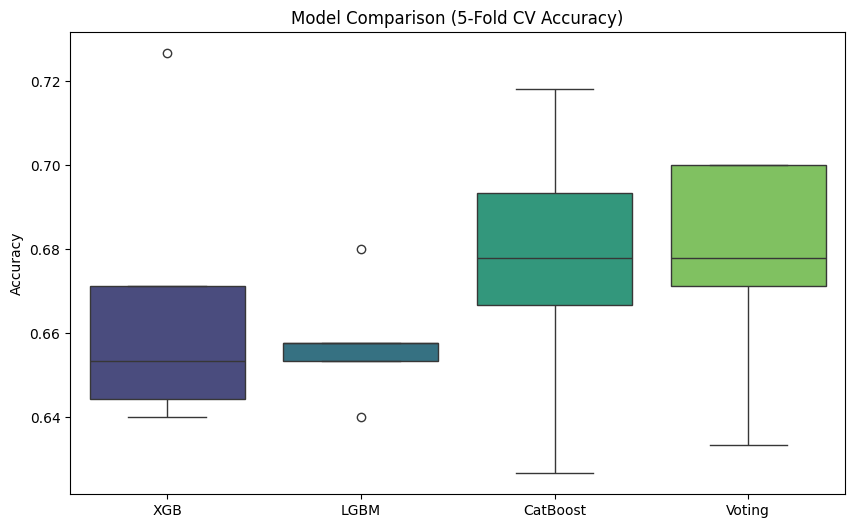

In [17]:
# 모델 성능 비교 시각화
result_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=result_df, palette='viridis')
plt.title('Model Comparison (5-Fold CV Accuracy)')
plt.ylabel('Accuracy')
plt.show()

In [19]:
# 최종 모델 학습 (Voting Classifier)
print("전체 데이터로 최종 모델 학습 중...")
final_model = voting_clf
final_model.fit(X.values, y.values)
print("학습 완료!")

전체 데이터로 최종 모델 학습 중...
학습 완료!


/tmp/ipython-input-3111528093.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20.values, y=top_20.index, palette='viridis')


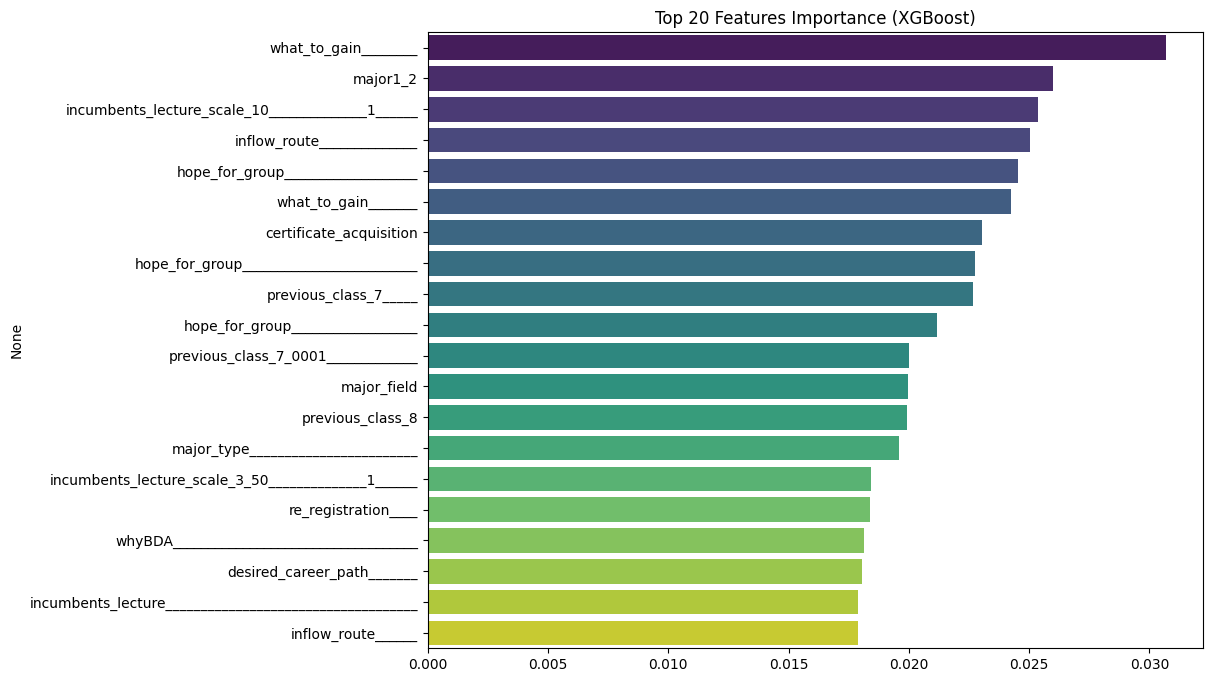

In [21]:
# (참고) XGBoost의 변수 중요도 확인
# Voting은 변수 중요도를 직접 제공하지 않으므로 단일 모델 중 하나를 확인합니다.
xgb_clf.fit(X.values, y.values)
feature_importances = pd.Series(xgb_clf.feature_importances_, index=X.columns)
top_20 = feature_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_20.values, y=top_20.index, palette='viridis')
plt.title('Top 20 Features Importance (XGBoost)')
plt.show()

In [22]:
# 테스트 데이터 예측 및 제출 파일 생성
predictions = final_model.predict(X_test)

# Raw Data에서 ID 가져오기 (GitHub에서 로드)
raw_test = pd.read_csv(RAW_TEST_URL)

submission = pd.DataFrame({
    'ID': raw_test['ID'],
    'completed': predictions
})

# 저장 (현재 작업 경로에 저장)
submission.to_csv('submission_ensemble.csv', index=False)
print("제출 파일 저장 완료: submission_ensemble.csv")
print(submission.head())

AttributeError: 'DataFrame' object has no attribute 'dtype'